In [3]:
# Importing required libraries
from sklearn.model_selection import RepeatedKFold
import catboost
from catboost import datasets
from sklearn.metrics import accuracy_score, confusion_matrix
from bayes_opt import BayesianOptimization
import shap
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier, Pool
import numpy as np
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import *
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import KFold
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import os
from scipy.stats import spearmanr
from sklearn.metrics import mean_squared_error  # Ensure this import is included
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [1]:
# Set up image format
%config InlineBackend.figure_format = 'svg'

In [2]:
# CatBoost check-up
print(catboost.__version__)
!python --version

1.2.3
Python 3.9.18


In [4]:
# Reading input datasets
ams,preds = pd.read_csv('ams_21.csv'), pd.read_csv('ams_21_preds.csv')

In [5]:
# Income and id columns selection
income = ams['income']
id = preds['id']

In [6]:
# Normalising variables
first_col = ams.iloc[:, 0]
remaining_cols = ams.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the remaining columns of X and transform them
remaining_scaled = pd.DataFrame(scaler.fit_transform(remaining_cols), columns=remaining_cols.columns)

# Reset indices to ensure they align for concatenation
first_col = first_col.reset_index(drop=True)
remaining_scaled = remaining_scaled.reset_index(drop=True)

# Concatenate the first column back with the scaled remaining columns
ams = pd.concat([first_col, remaining_scaled], axis=1)



In [7]:
# Normalising variables
first_col = preds.iloc[:, 0]
remaining_cols = preds.iloc[:, 1:]

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler on the remaining columns of X and transform them
remaining_scaled = pd.DataFrame(scaler.fit_transform(remaining_cols), columns=remaining_cols.columns)

# Reset indices to ensure they align for concatenation
first_col = first_col.reset_index(drop=True)
remaining_scaled = remaining_scaled.reset_index(drop=True)

# Concatenate the first column back with the scaled remaining columns
preds = pd.concat([first_col, remaining_scaled], axis=1)



In [8]:
ams

,income,colour_hue_disorderliness_mean,colour_hue_coherence_mean,colour_hue_contrast_std,surface_volume_disorderliness_mean,tcap_wetness_mean,ndwi_wetness_contrast_mean,tcap_wetness_disorderliness_mean,ndwi_wetness_coherence_std,tcap_wetness_coherence_mean,tcap_built_coherence_std,tcap_built_disorderliness_std,colour_brightness_coherence_mean,colour_brightness_disorderliness_mean,colour_saturation_mean,surface_structure_disorderliness_mean,tcap_greenness_std,tcap_greenness_contrast_mean,surface_structure_coherence_mean,surface_roughness_disorderliness_mean
0,00-20 low,0.726059,0.426929,0.334870,0.000000,0.919696,0.235872,0.935805,0.027511,0.714513,0.048663,0.068849,0.847768,0.462126,0.452945,0.397505,0.436257,0.330853,0.812404,0.252643
1,00-20 low,0.481959,0.249474,0.330897,0.693641,0.853505,0.104905,0.957794,0.272502,0.430002,0.096728,0.004344,0.814593,0.877211,0.069546,0.329862,0.231976,0.125872,0.632547,0.654629
2,00-20 low,0.347801,0.185874,0.094477,0.664655,0.839336,0.075464,0.943941,0.529012,0.349437,0.129242,0.007513,0.786678,0.803349,0.196449,0.344424,0.146458,0.128753,0.625283,0.559893
3,00-20 low,0.726146,0.241381,0.655134,0.496231,0.838180,0.259656,0.978852,0.117812,0.429744,0.130132,0.000477,0.729146,0.940991,0.117545,0.426069,0.168820,0.268881,0.814505,0.508024
4,00-20 low,0.433110,0.364161,0.232520,0.628856,0.796179,0.224478,0.972135,0.186703,0.457397,0.059668,0.001705,0.823930,0.918393,0.304509,0.416545,0.136739,0.284461,0.775748,0.618164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4270,80-100 high,0.507535,0.405231,0.068785,0.000000,0.858316,0.175434,0.957605,0.269521,0.697957,0.170667,0.020030,0.429592,0.345556,0.353493,0.266026,0.521615,0.274447,0.649050,0.048518
4271,80-100 high,0.701909,0.258131,0.188007,0.000000,0.729440,0.234556,0.974103,0.225528,0.817231,0.102940,0.005142,0.427578,0.471720,0.317625,0.760663,0.278958,0.320349,0.649175,0.395648
4272,80-100 high,0.586133,0.674648,0.069864,0.000000,0.842346,0.272499,0.954279,0.073447,0.596692,0.015853,0.007807,0.866374,0.547160,0.576790,0.334304,0.745315,0.368118,0.605730,0.003577
4273,80-100 high,0.534161,0.810074,0.028627,0.000000,0.844671,0.144099,0.247657,0.173741,0.882138,0.288448,0.604365,0.654148,0.432019,0.241295,0.313821,0.216885,0.493690,0.729215,0.082831


In [9]:
# Creating X/y dataframes
y = ams.income
X = preds.drop('id', axis=1)

In [10]:
# Dropping geographic coordinates
X = X.drop('x_coord', axis=1)
X = X.drop('y_coord', axis=1)

In [11]:
X

,colour_hue_disorderliness_mean,colour_hue_coherence_mean,colour_hue_contrast_std,surface_volume_disorderliness_mean,tcap_wetness_mean,ndwi_wetness_contrast_mean,tcap_wetness_disorderliness_mean,ndwi_wetness_coherence_std,tcap_wetness_coherence_mean,tcap_built_coherence_std,tcap_built_disorderliness_std,colour_brightness_coherence_mean,colour_brightness_disorderliness_mean,colour_saturation_mean,surface_structure_disorderliness_mean,tcap_greenness_std,tcap_greenness_contrast_mean,surface_structure_coherence_mean,surface_roughness_disorderliness_mean
0,0.726059,0.426929,0.334870,0.000000,0.919696,0.235872,0.935805,0.027511,0.714513,0.048663,0.068849,0.847768,0.462126,0.452945,0.397505,0.436257,0.330853,0.812404,0.252643
1,0.481959,0.249474,0.330897,0.693641,0.853505,0.104905,0.957794,0.272502,0.430002,0.096728,0.004344,0.814593,0.877211,0.069546,0.329862,0.231976,0.125872,0.632547,0.654629
2,0.347801,0.185874,0.094477,0.664655,0.839336,0.075464,0.943941,0.529012,0.349437,0.129242,0.007513,0.786678,0.803349,0.196449,0.344424,0.146458,0.128753,0.625283,0.559893
3,0.726146,0.241381,0.655134,0.496231,0.838180,0.259656,0.978852,0.117812,0.429744,0.130132,0.000477,0.729146,0.940991,0.117545,0.426069,0.168820,0.268881,0.814505,0.508024
4,0.433110,0.364161,0.232520,0.628856,0.796179,0.224478,0.972135,0.186703,0.457397,0.059668,0.001705,0.823930,0.918393,0.304509,0.416545,0.136739,0.284461,0.775748,0.618164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4270,0.507535,0.405231,0.068785,0.000000,0.858316,0.175434,0.957605,0.269521,0.697957,0.170667,0.020030,0.429592,0.345556,0.353493,0.266026,0.521615,0.274447,0.649050,0.048518
4271,0.701909,0.258131,0.188007,0.000000,0.729440,0.234556,0.974103,0.225528,0.817231,0.102940,0.005142,0.427578,0.471720,0.317625,0.760663,0.278958,0.320349,0.649175,0.395648
4272,0.586133,0.674648,0.069864,0.000000,0.842346,0.272499,0.954279,0.073447,0.596692,0.015853,0.007807,0.866374,0.547160,0.576790,0.334304,0.745315,0.368118,0.605730,0.003577
4273,0.534161,0.810074,0.028627,0.000000,0.844671,0.144099,0.247657,0.173741,0.882138,0.288448,0.604365,0.654148,0.432019,0.241295,0.313821,0.216885,0.493690,0.729215,0.082831


In [12]:
y

0         00-20 low
1         00-20 low
2         00-20 low
3         00-20 low
4         00-20 low
           ...     
4270    80-100 high
4271    80-100 high
4272    80-100 high
4273    80-100 high
4274    80-100 high
Name: income, Length: 4275, dtype: object

In [13]:
dataset_dir = './inc_ams'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# We will be able to work with files with/without header and
# with different separators.

ams.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
preds.to_csv(
    os.path.join(dataset_dir, 'preds.csv'),
    index=False, sep=',', header=True
)

In [14]:
pool1 = Pool(data=X, label=y)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

Dataset shape
dataset 1:(4275, 19)


Column names
dataset 1:
['colour_hue_disorderliness_mean', 'colour_hue_coherence_mean', 'colour_hue_contrast_std', 'surface_volume_disorderliness_mean', 'tcap_wetness_mean', 'ndwi_wetness_contrast_mean', 'tcap_wetness_disorderliness_mean', 'ndwi_wetness_coherence_std', 'tcap_wetness_coherence_mean', 'tcap_built_coherence_std', 'tcap_built_disorderliness_std', 'colour_brightness_coherence_mean', 'colour_brightness_disorderliness_mean', 'colour_saturation_mean', 'surface_structure_disorderliness_mean', 'tcap_greenness_std', 'tcap_greenness_contrast_mean', 'surface_structure_coherence_mean', 'surface_roughness_disorderliness_mean']


TBB Warning: The number of workers is currently limited to 5. The request for 39 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



In [15]:
# Train/validation split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [16]:
# Hyperparameters optimisation

# Define the function to optimize
def catboost_cv(learning_rate, iterations, depth, l2_leaf_reg):
    # Convert continuous parameters to integer where necessary
    iterations = int(iterations)
    depth = int(round(depth))
    l2_leaf_reg = int(round(l2_leaf_reg))
    
    # Initialize KFold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    train_f1_scores = []
    validation_f1_scores = []
    
    # Perform 5-fold cross-validation
    for train_index, test_index in kf.split(X):
        X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        train_pool = Pool(data=X_train_fold, label=y_train_fold)
        test_pool = Pool(data=X_test_fold, label=y_test_fold)
        
        # Define and train the model
        model = CatBoostClassifier(
            learning_rate=learning_rate,
            iterations=iterations,
            depth=depth,
            l2_leaf_reg=l2_leaf_reg,
            loss_function='MultiClass',
            eval_metric='TotalF1',
            random_seed=42,
            logging_level='Silent'
        )
        
        model.fit(train_pool, eval_set=test_pool, use_best_model=True)
        
        # Predict on training and validation data
        y_train_pred = model.predict(X_train_fold)
        y_test_pred = model.predict(X_test_fold)
        
        # Calculate F1 scores
        train_f1 = f1_score(y_train_fold, y_train_pred, average='weighted')
        validation_f1 = f1_score(y_test_fold, y_test_pred, average='weighted')
        
        train_f1_scores.append(train_f1)
        validation_f1_scores.append(validation_f1)
    
    # Calculate average F1 scores across all folds
    avg_train_f1 = np.mean(train_f1_scores)
    avg_validation_f1 = np.mean(validation_f1_scores)
    
    # Calculate the difference between training and validation F1 scores
    f1_difference = avg_train_f1 - avg_validation_f1
    
    # Return a very low score if the F1 difference exceeds 0.1
    if f1_difference > 0.1:
        return 0
    
    # Store the results for comparison
    results.append({
        'learning_rate': learning_rate,
        'iterations': iterations,
        'depth': depth,
        'l2_leaf_reg': l2_leaf_reg,
        'avg_train_f1': avg_train_f1,
        'avg_validation_f1': avg_validation_f1,
        'f1_difference': f1_difference
    })
    
    return avg_validation_f1

# Define the initial bounds for hyperparameters
param_bounds = {
    'learning_rate': (0.01, 0.1), 
    'iterations': (500, 2000), 
    'depth': (2, 3), 
    'l2_leaf_reg': (1, 120)
}

# List to store results
results = []

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=catboost_cv,
    pbounds=param_bounds,
    random_state=63,
    verbose=2
)

# Perform optimization
optimizer.maximize(
    init_points=20,  # Number of initial random points
    n_iter=40       # Number of optimization iterations
)

# Extract the best parameters
best_params = optimizer.max['params']
best_params['iterations'] = int(best_params['iterations'])
best_params['depth'] = int(round(best_params['depth']))
best_params['l2_leaf_reg'] = int(round(best_params['l2_leaf_reg']))

print("Best hyperparameters found were:")
print(best_params)

# Print train/test F1 score comparison
for result in results:
    print(f"Parameters: learning_rate={result['learning_rate']}, iterations={result['iterations']}, depth={result['depth']}, l2_leaf_reg={result['l2_leaf_reg']}")
    print(f"Average Train F1 Score: {result['avg_train_f1']}, Average Validation F1 Score: {result['avg_validation_f1']}, F1 Score Difference: {result['f1_difference']}\n")


|   iter    |  target   |   depth   | iterat... | l2_lea... | learni... |
-------------------------------------------------------------------------
| 1         | 0.0       | 2.554     | 1.094e+03 | 6.727     | 0.05731   |
| 2         | 0.3984    | 2.153     | 1.25e+03  | 31.47     | 0.05888   |
| 3         | 0.0       | 2.548     | 838.7     | 11.62     | 0.05067   |
| 4         | 0.0       | 2.773     | 1.523e+03 | 103.6     | 0.05085   |
| 5         | 0.3837    | 2.569     | 507.9     | 105.1     | 0.06201   |
| 6         | 0.0       | 2.945     | 1.838e+03 | 82.14     | 0.09013   |
| 7         | 0.0       | 2.193     | 1.704e+03 | 3.786     | 0.09284   |
| 8         | 0.0       | 2.669     | 1.613e+03 | 115.9     | 0.04598   |
| 9         | 0.3968    | 2.315     | 1.237e+03 | 36.18     | 0.05873   |
| 10        | 0.3725    | 2.293     | 853.8     | 84.25     | 0.04122   |
| 11        | 0.4007    | 2.459     | 1.404e+03 | 14.12     | 0.04615   |
| 12        | 0.3741    | 2.262     | 

In [20]:

# Create a CatBoost classifier instance
tuned_model = CatBoostClassifier(
    random_seed=64,
    iterations=843,
    task_type="CPU",
    learning_rate=0.06990330171050001,
    l2_leaf_reg=65,
    depth=3,
    loss_function='MultiClass'
)

# Fit the model
tuned_model.fit(
    X_train, y_train,
    verbose=False,
    eval_set=(X_validation, y_validation),
    early_stopping_rounds=50,  # Stops if the chosen metric doesn't improve in 50 rounds
    plot=False  # Plots the metric during training
)

# Get results of the evaluation
results = tuned_model.get_evals_result()


In [21]:
# Cross-validation for quality metrics retrieval

# Define the model with optimal parameters
tuned_model = CatBoostClassifier(
    random_seed=64,
    iterations=843,
    task_type="CPU",
    learning_rate=0.06990330171050001,
    l2_leaf_reg=65,
    depth=3,
    loss_function='MultiClass'
)

# Setup Repeated K-Fold cross-validation
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)

# Prepare lists to store results
train_accuracy_results = []
test_accuracy_results = []
train_f1_results = []
test_f1_results = []
train_auc_results = []
test_auc_results = []

# Loop over each fold
for train_index, test_index in rkf.split(X):
    train_pool = Pool(X.iloc[train_index], y.iloc[train_index])
    test_pool = Pool(X.iloc[test_index], y.iloc[test_index])

    # Fit model
    tuned_model.fit(train_pool, eval_set=test_pool, verbose=False)

    # Predict on train and test sets
    train_predictions = tuned_model.predict(train_pool)
    test_predictions = tuned_model.predict(test_pool)
    
    # Predict probabilities for AUC calculation
    train_probabilities = tuned_model.predict_proba(train_pool)
    test_probabilities = tuned_model.predict_proba(test_pool)

    # Calculate Accuracy
    train_accuracy = accuracy_score(y.iloc[train_index], train_predictions)
    test_accuracy = accuracy_score(y.iloc[test_index], test_predictions)
    train_accuracy_results.append(train_accuracy)
    test_accuracy_results.append(test_accuracy)

    # Calculate F1 Score (macro)
    train_f1 = f1_score(y.iloc[train_index], train_predictions, average='macro')
    test_f1 = f1_score(y.iloc[test_index], test_predictions, average='macro')
    train_f1_results.append(train_f1)
    test_f1_results.append(test_f1)

    # Calculate AUC (macro, multi_class='ovr')
    train_auc = roc_auc_score(y.iloc[train_index], train_probabilities, multi_class='ovr', average='macro')
    test_auc = roc_auc_score(y.iloc[test_index], test_probabilities, multi_class='ovr', average='macro')
    train_auc_results.append(train_auc)
    test_auc_results.append(test_auc)

# Calculate the average and standard deviation of metrics across all train and test folds
mean_train_accuracy = np.mean(train_accuracy_results)
std_train_accuracy = np.std(train_accuracy_results)
mean_test_accuracy = np.mean(test_accuracy_results)
std_test_accuracy = np.std(test_accuracy_results)

mean_train_f1 = np.mean(train_f1_results)
std_train_f1 = np.std(train_f1_results)
mean_test_f1 = np.mean(test_f1_results)
std_test_f1 = np.std(test_f1_results)

mean_train_auc = np.mean(train_auc_results)
std_train_auc = np.std(train_auc_results)
mean_test_auc = np.mean(test_auc_results)
std_test_auc = np.std(test_auc_results)

print("Average Train Accuracy:", mean_train_accuracy)
print("Train Accuracy Standard Deviation:", std_train_accuracy)
print("Average Test Accuracy:", mean_test_accuracy)
print("Test Accuracy Standard Deviation:", std_test_accuracy)
print("Average Train F1 Score:", mean_train_f1)
print("Train F1 Score Standard Deviation:", std_train_f1)
print("Average Test F1 Score:", mean_test_f1)
print("Test F1 Score Standard Deviation:", std_test_f1)
print("Average Train AUC:", mean_train_auc)
print("Train AUC Standard Deviation:", std_train_auc)
print("Average Test AUC:", mean_test_auc)
print("Test AUC Standard Deviation:", std_test_auc)


Average Train Accuracy: 0.5319493177387914
Train Accuracy Standard Deviation: 0.003953992949242281
Average Test Accuracy: 0.4112280701754385
Test Accuracy Standard Deviation: 0.021620245008862483
Average Train F1 Score: 0.49752784543044243
Train F1 Score Standard Deviation: 0.005418338227764792
Average Test F1 Score: 0.3772843009339735
Test F1 Score Standard Deviation: 0.024065808025049134
Average Train AUC: 0.8136834145233247
Train AUC Standard Deviation: 0.0021203957461068965
Average Test AUC: 0.7138936761688324
Test AUC Standard Deviation: 0.013858779622591988


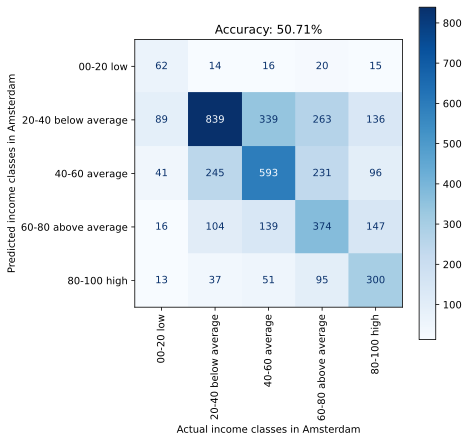

In [22]:
# Confusion matrix 
class_names = ['00-20 low', '20-40 below average', '40-60 average', '60-80 above average', '80-100 high']

# Ensure 'y' is a single-column DataFrame and convert it to a Series
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

# Make predictions using the CatBoost model
predicted_values = tuned_model.predict(X)

# Calculate accuracy
accuracy = accuracy_score(y, predicted_values) * 100

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y, predicted_values, labels=class_names)

# Transpose the confusion matrix to swap axes
conf_matrix = conf_matrix.T

# Plot confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))  # Create a figure and axis
disp.plot(cmap='Blues', xticks_rotation='vertical', ax=ax)
ax.set_title(f'\nAccuracy: {accuracy:.2f}%')
ax.set_xlabel('Actual income classes in Amsterdam')
ax.set_ylabel('Predicted income classes in Amsterdam')

# Save the plot as an SVG file
plt.savefig('confusion_matrix_ams_21.svg', format='svg')

# Show the plot
plt.show()


In [ ]:
# Extracting SHAP values

# Ensure 'y' is a single-column DataFrame and convert it to a Series if necessary
if isinstance(y, pd.DataFrame):
    y = y.iloc[:, 0]

# Convert 'y' to a numpy array
y = np.array(y)

# Initialize the SHAP explainer
explainer = shap.TreeExplainer(tuned_model)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X)

# For categorical targets, SHAP returns a list of arrays (one for each class)
# We will focus on the class '80-100 high'
target_class_index = class_names.index('80-100 high')
shap_values_for_class = shap_values[target_class_index]

# Ensure shap_values_for_class is a DataFrame
shap_df = pd.DataFrame(shap_values_for_class, columns=X.columns)

# Extract SHAP values for the specific predictor 'colour_hue_disorderliness_mean'
shap_tcap_wetness_mean = shap_df['tcap_wetness_mean']
shap_colour_brightness_coherence_mean = shap_df['colour_brightness_coherence_mean']
shap_tcap_wetness_disorderliness_mean = shap_df['tcap_wetness_disorderliness_mean']
shap_surface_roughness_disorderliness_mean = shap_df['surface_roughness_disorderliness_mean']
shap_ndwi_wetness_contrast_mean = shap_df['ndwi_wetness_contrast_mean']
shap_ndwi_wetness_coherence_std = shap_df['ndwi_wetness_coherence_std']
# Ensure all arrays are 1-dimensional
y = y.flatten()
predicted_values = tuned_model.predict(X).flatten()
shap_tcap_wetness_mean = shap_tcap_wetness_mean.values.flatten()
shap_colour_brightness_coherence_mean = shap_colour_brightness_coherence_mean.values.flatten()
shap_tcap_wetness_disorderliness_mean = shap_tcap_wetness_disorderliness_mean.values.flatten()
shap_surface_roughness_disorderliness_mean = shap_surface_roughness_disorderliness_mean.values.flatten()
shap_ndwi_wetness_contrast_mean = shap_ndwi_wetness_contrast_mean.values.flatten()
shap_ndwi_wetness_coherence_std = shap_ndwi_wetness_coherence_std.values.flatten()

# Create a DataFrame with actual values, predicted values, and SHAP values for 'colour_hue_disorderliness_mean'
results_with_shap_df = pd.DataFrame({
    'Actual': y,
    'Predicted': predicted_values,
    'SHAP_tcap_wetness_mean': shap_tcap_wetness_mean,
    'SHAP_colour_brightness_coherence_mean': shap_colour_brightness_coherence_mean,
    'SHAP_tcap_wetness_disorderliness_mean': shap_tcap_wetness_disorderliness_mean,
    'SHAP_surface_roughness_disorderliness_mean': shap_surface_roughness_disorderliness_mean,
    'SHAP_ndwi_wetness_contrast_mean': shap_ndwi_wetness_contrast_mean,
    'SHAP_ndwi_wetness_coherence_std': shap_ndwi_wetness_coherence_std
})

# Print the DataFrame
print(results_with_shap_df.head())


In [ ]:
combined_df = results_with_shap_df.join(income, how='inner')  # Use 'inner' join to keep only matching indices
combined_df

In [ ]:
combined_df = combined_df.join(id, how='inner')  # Use 'inner' join to keep only matching indices
combined_df

In [ ]:
# Error estimation
# Define the categories and their order
categories = ['00-20 low', '20-40 below average', '40-60 average', '60-80 above average', '80-100 high']

# Define the function to calculate the error
def calculate_error(actual, predicted, categories):
    actual_index = categories.index(actual)
    predicted_index = categories.index(predicted)
    difference = predicted_index - actual_index
    
    if difference == 0:
        return 'accurate'
    elif difference > 0:
        return f'overestimated {difference} class{"es" if difference > 1 else ""}'
    else:
        return f'underestimated {abs(difference)} class{"es" if abs(difference) > 1 else ""}'

# Apply the function to each row in the DataFrame
combined_df['Error'] = combined_df.apply(lambda row: calculate_error(row['Actual'], row['Predicted'], categories), axis=1)

# Display the DataFrame with the new column
combined_df

In [ ]:
combined_df.to_csv('pred_vs_actual_with_shap_and_id_ams.csv', index=False)

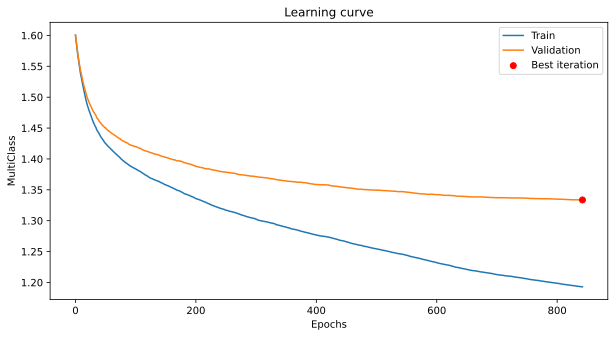

In [24]:
# Plotting training process
epochs = np.arange(len(results['learn']['MultiClass']))

# Retrieve the best iteration from the model
best_iteration = tuned_model.get_best_iteration()

plt.figure(figsize=(10, 5))
plt.plot(epochs, results['learn']['MultiClass'], label='Train')
plt.plot(epochs, results['validation']['MultiClass'], label='Validation')

# Mark the best iteration on the plot
if best_iteration is not None:
    plt.scatter(best_iteration, results['validation']['MultiClass'][best_iteration], color='red', zorder=5, label='Best iteration')

plt.xlabel('Epochs')
plt.ylabel('MultiClass')
plt.title('Learning curve')
plt.legend()
plt.show()


In [25]:
pool1 = Pool(data=X, label=y)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names()) 

Dataset shape
dataset 1:(4275, 19)


Column names
dataset 1:
['colour_hue_disorderliness_mean', 'colour_hue_coherence_mean', 'colour_hue_contrast_std', 'surface_volume_disorderliness_mean', 'tcap_wetness_mean', 'ndwi_wetness_contrast_mean', 'tcap_wetness_disorderliness_mean', 'ndwi_wetness_coherence_std', 'tcap_wetness_coherence_mean', 'tcap_built_coherence_std', 'tcap_built_disorderliness_std', 'colour_brightness_coherence_mean', 'colour_brightness_disorderliness_mean', 'colour_saturation_mean', 'surface_structure_disorderliness_mean', 'tcap_greenness_std', 'tcap_greenness_contrast_mean', 'surface_structure_coherence_mean', 'surface_roughness_disorderliness_mean']


In [26]:
metrics = tuned_model.eval_metrics(
    data=pool1,
    metrics=['TotalF1','AUC', 'Accuracy'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=False
)

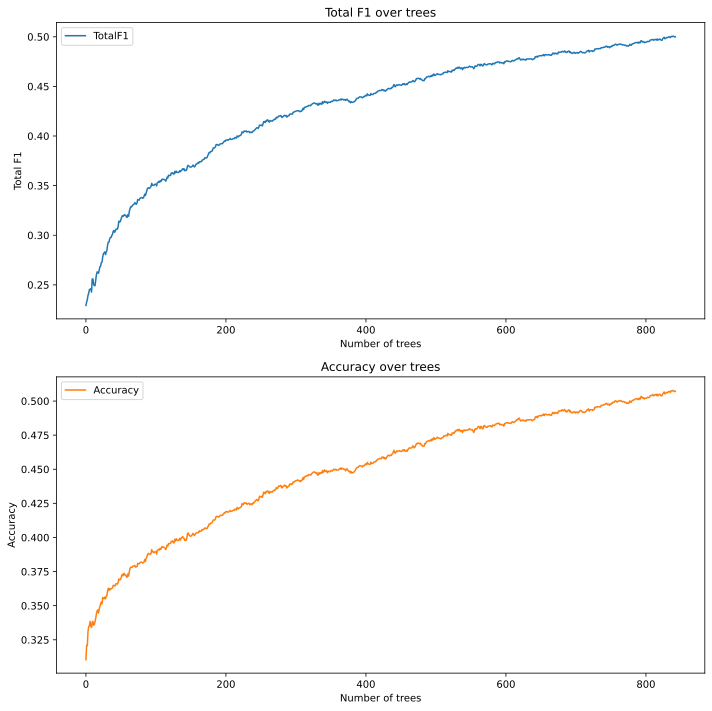

In [27]:
# Extracting metrics for plotting
rmse_values = metrics['TotalF1']
r2_values = metrics['Accuracy']
trees = list(range(len(rmse_values)))  # Assuming eval_period=1 and starting from the first tree

# Creating subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# Plotting RMSE
axs[0].plot(trees, rmse_values, label='TotalF1', color='tab:blue')
axs[0].set_title('Total F1 over trees')
axs[0].set_xlabel('Number of trees')
axs[0].set_ylabel('Total F1')
axs[0].legend()

# Plotting R2
axs[1].plot(trees, r2_values, label='Accuracy', color='tab:orange')
axs[1].set_title('Accuracy over trees')
axs[1].set_xlabel('Number of trees')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()
plt.show()


In [28]:
tuned_model.get_feature_importance(prettified=True)

,Feature Id,Importances
0,colour_hue_disorderliness_mean,10.751295
1,colour_brightness_disorderliness_mean,10.706945
2,ndwi_wetness_contrast_mean,9.364743
3,tcap_wetness_mean,7.242626
4,colour_brightness_coherence_mean,6.427868
5,tcap_greenness_contrast_mean,5.785174
6,tcap_wetness_coherence_mean,4.811735
7,tcap_wetness_disorderliness_mean,4.694584
8,surface_volume_disorderliness_mean,4.556102
9,surface_roughness_disorderliness_mean,4.422888


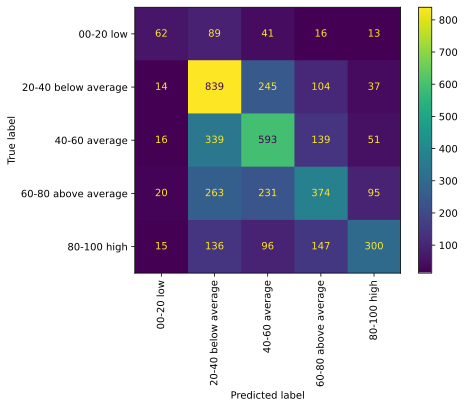

In [29]:

class_names = ['00-20 low', '20-40 below average', '40-60 average', '60-80 above average', '80-100 high']

# Plotting the confusion matrix
disp = ConfusionMatrixDisplay.from_estimator(
    tuned_model,
    X,
    y,
    display_labels=class_names,
    xticks_rotation='vertical'
)

plt.show()


In [30]:
params = tuned_model.get_params()
params['loss_function'] = 'MultiClass'
params['custom_loss'] = 'TotalF1'


cv_data = cv(
    params = params,
    pool = Pool(X, label=y),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=False,
    stratified=False,
    verbose=False
)

Training on fold [0/5]

bestTest = 1.31991186
bestIteration = 841

Training on fold [1/5]

bestTest = 1.327881005
bestIteration = 840

Training on fold [2/5]

bestTest = 1.322213582
bestIteration = 842

Training on fold [3/5]

bestTest = 1.357166998
bestIteration = 841

Training on fold [4/5]

bestTest = 1.352030817
bestIteration = 842



In [31]:
cv_data

,iterations,test-MultiClass-mean,test-MultiClass-std,train-MultiClass-mean,train-MultiClass-std,test-TotalF1-mean,test-TotalF1-std,train-TotalF1-mean,train-TotalF1-std
0,0,1.600055,0.000714,1.599703,0.000952,0.224137,0.022647,0.228801,0.019673
1,1,1.591695,0.001304,1.590779,0.001029,0.225561,0.022840,0.235938,0.018929
2,2,1.584398,0.002195,1.582868,0.001696,0.211341,0.035272,0.223226,0.014355
3,3,1.576623,0.002332,1.574605,0.001808,0.236298,0.024268,0.245518,0.009317
4,4,1.569213,0.003214,1.566825,0.001918,0.227411,0.026924,0.242754,0.013337
...,...,...,...,...,...,...,...,...,...
838,838,1.336017,0.017520,1.194358,0.004835,0.399695,0.005788,0.524279,0.005013
839,839,1.336000,0.017528,1.194202,0.004791,0.400936,0.006051,0.523630,0.005254
840,840,1.335949,0.017507,1.193944,0.004908,0.401099,0.005991,0.523903,0.004745
841,841,1.335861,0.017453,1.193730,0.004935,0.400753,0.006172,0.523879,0.004622


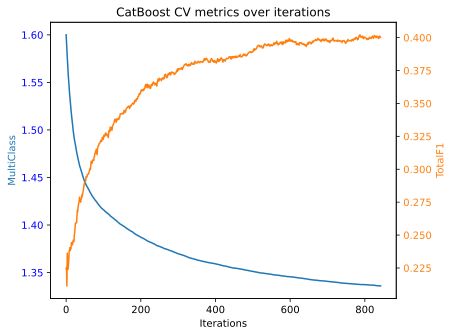

In [32]:
# Extracting the mean RMSE and R2 values from cv_data
mean_multiclass = cv_data['test-MultiClass-mean']
mean_f1 = cv_data['test-TotalF1-mean']
iterations = range(len(mean_multiclass))

# Plotting the RMSE and R2 values
fig, ax1 = plt.subplots()

ax1.set_xlabel('Iterations')
ax1.set_ylabel('MultiClass', color='tab:blue')
ax1.plot(iterations, mean_multiclass, label='MultiClass', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()
ax2.set_ylabel('TotalF1', color='tab:orange')
ax2.plot(iterations, mean_f1, label='TotalF1', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Title and legend
plt.title('CatBoost CV metrics over iterations')
fig.tight_layout()  # To ensure the right y-label is not clipped
plt.show()

In [33]:
multiclass_values = cv_data['train-MultiClass-mean']
f1_values = cv_data['train-TotalF1-mean']

# Create a DataFrame with both RMSE and R2 values
cv_results_df = pd.DataFrame({'MultiClass': multiclass_values, 'TotalF1': f1_values})
cv_results_df

,MultiClass,TotalF1
0,1.599703,0.228801
1,1.590779,0.235938
2,1.582868,0.223226
3,1.574605,0.245518
4,1.566825,0.242754
...,...,...
838,1.194358,0.524279
839,1.194202,0.523630
840,1.193944,0.523903
841,1.193730,0.523879


In [34]:
multiclass_values = cv_data['test-MultiClass-mean']
f1_values = cv_data['test-TotalF1-mean']

# Create a DataFrame with both RMSE and R2 values
cv_results_df = pd.DataFrame({'MultiClass': multiclass_values, 'TotalF1': f1_values})
cv_results_df

,MultiClass,TotalF1
0,1.600055,0.224137
1,1.591695,0.225561
2,1.584398,0.211341
3,1.576623,0.236298
4,1.569213,0.227411
...,...,...
838,1.336017,0.399695
839,1.336000,0.400936
840,1.335949,0.401099
841,1.335861,0.400753


In [36]:
shap_values = tuned_model.get_feature_importance(pool1, fstr_type='ShapValues')
print(shap_values.shape)

(4275, 5, 20)


In [37]:
explainer = shap.TreeExplainer(tuned_model)
shap_values = explainer.shap_values(Pool(X, y))

#shap.initjs()
#shap.force_plot(explainer.expected_value[0],shap_values[0])

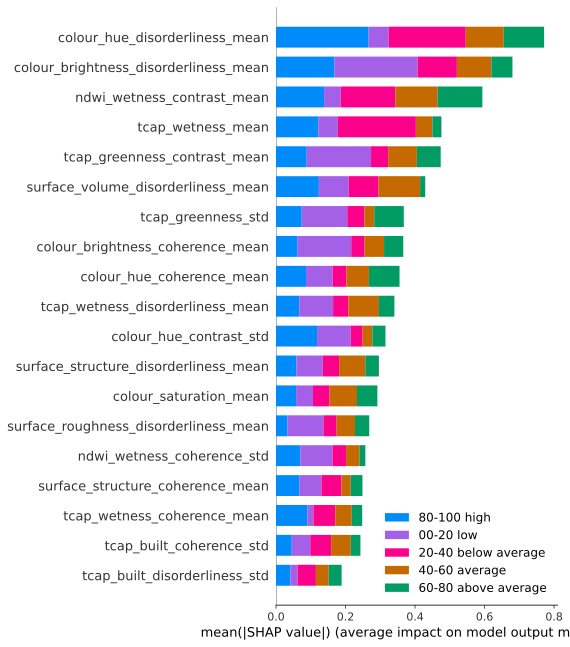

Text(0.5, 1.0, 'The Summary Plot for the Multiclass Model\nClass 2 - Best, Class 1 - Premium, Class 0 - Value')

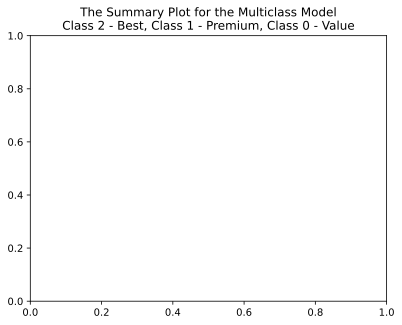

In [38]:
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)
plt.title('The Summary plot for the Multiclass model'+'\n'+'Class 2 - Best, Class 1 - Premium, Class 0 - Value')

In [39]:
from sklearn.preprocessing import LabelEncoder

labels = [
    "00-20 low",
    "20-40 below average",
    "40-60 average",
    "60-80 above average",
    "80-100 high",
]
le = LabelEncoder()
y = le.fit_transform(labels)
encoding_scheme = dict(zip(y, labels))
print(encoding_scheme)

{0: '00-20 low', 1: '20-40 below average', 2: '40-60 average', 3: '60-80 above average', 4: '80-100 high'}


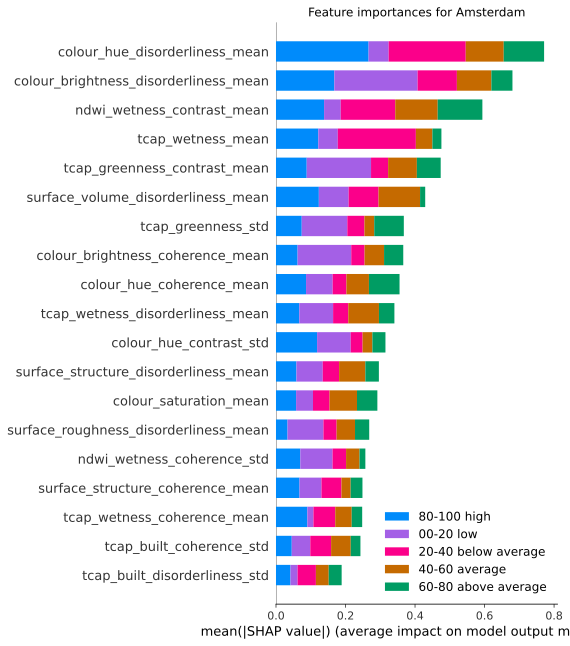

In [40]:
plt.title('Feature importances for Amsterdam')
shap.summary_plot(shap_values, X.values, plot_type="bar", class_names= class_names, feature_names = X.columns)

In [41]:

plt.switch_backend('Agg')

# Set the title of the plot
plt.title('Impact on low income in Amsterdam')

# Generate SHAP summary plot
shap.summary_plot(shap_values[0], X.values, feature_names=X.columns, show=False)  # Set show=False to prevent immediate display

# After generating the plot, get the current figure
fig = plt.gcf()

# Save the current figure in SVG format
fig.savefig("shap_dependency_plot_lowAMS_rs.svg", format='svg', bbox_inches='tight')

# Optionally, close the figure to free up memory
plt.close(fig)


In [42]:
plt.title('Impact on income below average in Amsterdam')
shap.summary_plot(shap_values[1], X.values, feature_names = X.columns)

In [43]:
plt.title('Impact on average income in Amsterdam')
shap.summary_plot(shap_values[2], X.values, feature_names = X.columns)

In [44]:
plt.title('Impact on income above average in Amsterdam')
shap.summary_plot(shap_values[3], X.values, feature_names = X.columns)

In [45]:
# Switch to 'Agg' backend, which is better suited for file outputs
plt.switch_backend('Agg')

# Set the title of the plot
plt.title('Impact on high income in Amsterdam')

# Generate SHAP summary plot
shap.summary_plot(shap_values[4], X.values, feature_names=X.columns, show=False)  # Set show=False to prevent immediate display

# After generating the plot, get the current figure
fig = plt.gcf()

# Save the current figure in SVG format
fig.savefig("shap_dependency_plot_highAMS_rs.svg", format='svg', bbox_inches='tight')

# Optionally, close the figure to free up memory
plt.close(fig)


Auto-close()ing of figures upon backend switching is deprecated since 3.8 and will be removed two minor releases later.  To suppress this warning, explicitly call plt.close('all') first.
